<a href="https://colab.research.google.com/github/koheikobayashi/AR-name-card/blob/main/%E9%80%9D%E5%8E%BB%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install japanize_matplotlib
!pip install --upgrade polars
!pip install uvicorn
!pip install fastapi
!pip install xgboost==1.7.6 scikit-learn==1.2.2

import pandas as pd
import re
import plotly.express as px
import plotly.graph_objects as go
import os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import plotly.figure_factory as ff
import os
from typing import Union
import polars as pl

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

from google.colab import drive
drive.mount('/content/drive')

# ファイル読み込み

In [2]:
import sqlite3
import pandas as pd

# --------------------------------------------------
# 1. データベースへの接続
# --------------------------------------------------
# eICUのSQLiteファイルへのパスを指定
db_path = "./drive/MyDrive/データ分析/bsc/eicu_v2_0_1.sqlite3"

# SQLiteに接続
conn = sqlite3.connect(db_path)

# --------------------------------------------------
# 2. 患者テーブル(patient)から必要カラムを抽出
# --------------------------------------------------
query_patient = """
SELECT
    patientunitstayid,
    hospitaldischargestatus,  -- 退院時の生死情報 (Alive/Expiredなど)
    age,
    gender,
    admissionheight,
    admissionweight,
    hospitaladmittime24,
    hospitaldischargetime24
FROM patient
"""

df_patient = pd.read_sql(query_patient, conn)

# --------------------------------------------------
# 3. vitalPeriodicテーブルから血圧, 脈拍, 体温を抽出
# --------------------------------------------------
query_vitals = """
SELECT
    patientunitstayid,
    observationoffset,  -- 観測時間 (分単位)
    systemicsystolic,           -- 収縮期血圧
    systemicdiastolic,          -- 拡張期血圧
    heartrate,          -- 脈拍
    temperature         -- 体温
FROM vitalPeriodic
WHERE systemicsystolic IS NOT ''
   AND systemicdiastolic IS NOT ''
   AND heartrate IS NOT ''
   AND temperature IS NOT ''
"""

df_vitals = pd.read_sql(query_vitals, conn)
# df_vitals["systemicsystolic"] = df_vitals["systemicsystolic"].astype(float)
# df_vitals["systemicdiastolic"] = df_vitals["systemicdiastolic"].astype(float)
# df_vitals["heartrate"] = df_vitals["heartrate"].astype(float)
# df_vitals["temperature"] = df_vitals["temperature"].astype(float)

# 例: 時系列データを患者ごとに平均値で集約
df_vitals_agg = (
    df_vitals
    .groupby("patientunitstayid")[["systemicsystolic", "systemicdiastolic", "heartrate", "temperature"]]
    .mean()
    .reset_index()
)

# --------------------------------------------------
# 4. labテーブルから必要データを抽出
# --------------------------------------------------
query_lab = """
SELECT
    patientunitstayid,
    labname,
    labresult,
    labresultoffset
FROM lab
"""

df_lab_raw = pd.read_sql(query_lab, conn)

# 例: labテーブルから特定項目だけを抽出
target_labs = ["glucose", "creatinine", "hemoglobin"]  # 例
df_lab_filtered = df_lab_raw[df_lab_raw["labname"].isin(target_labs)]
df_lab_filtered["labresult"] = pd.to_numeric(df_lab_filtered["labresult"], errors="coerce")
df_lab_filtered["labresult"] = df_lab_filtered["labresult"].astype(float)

# 例: 各ラボ値を患者ごとに平均・最大・最小などに集約
df_lab_agg = (
    df_lab_filtered
    .groupby(["patientunitstayid", "labname"])["labresult"]
    .agg(["mean", "max", "min"])
    .reset_index()
)

# 集約結果をPivotして列を広げる
df_lab_pivot = df_lab_agg.pivot(
    index="patientunitstayid",
    columns="labname",
    values=["mean", "max", "min"]
)

# 列名をフラット化（階層インデックスの解消）
df_lab_pivot.columns = [
    f"{stat}_{labname}" for stat, labname in df_lab_pivot.columns
]

# patientunitstayid でインデックスになっているので列として復帰
df_lab_pivot.reset_index(inplace=True)

# --------------------------------------------------
# 5. テーブルの結合 (patient, vitalPeriodic, labデータを結合)
# --------------------------------------------------
df_merged = pd.merge(df_patient, df_vitals_agg, how="left", on="patientunitstayid")
df_merged = pd.merge(df_merged, df_lab_pivot, how="left", on="patientunitstayid")

# --------------------------------------------------
# 6. 退院時ステータスから生死ラベルを作成
# --------------------------------------------------
df_merged["mortality_label"] = df_merged["hospitaldischargestatus"].apply(
    lambda x: 1 if x == "Expired" else 0
)

# --------------------------------------------------
# 7. 不要な列などの処理・欠損値の処理
# --------------------------------------------------
# 不要カラム(例: hospitaldischargetime24)を削除
cols_to_drop = ["hospitaldischargetime24"]
df_merged.drop(columns=cols_to_drop, inplace=True, errors="ignore")

# age列などに欠損がある場合の処理例
df_merged["age"] = pd.to_numeric(df_merged["age"], errors="coerce")
df_merged["age"] = df_merged["age"].fillna(0).astype(int)
df_merged["age"].fillna(df_merged["age"].median(), inplace=True)

# 欠損値の処理
df_merged.fillna(-1, inplace=True)  # 単純に-1で埋めるなど(研究目的に応じて要調整)

# --------------------------------------------------
# 8. 特徴量とラベルの分割 (機械学習用)
# --------------------------------------------------
# 例: mortality_label 以外を特徴量とし、mortality_label をラベルとする
feature_columns = [col for col in df_merged.columns if col not in
                   ["patientunitstayid", "hospitaldischargestatus", "mortality_label"]]

X = df_merged[feature_columns]
y = df_merged["mortality_label"]

# --------------------------------------------------
# 9. データベース接続を閉じる
# --------------------------------------------------
conn.close()

<ipython-input-2-d27b189f7e8e>:129: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["age"].fillna(df_merged["age"].median(), inplace=True)


In [3]:
df_merged.head()

,patientunitstayid,hospitaldischargestatus,age,gender,admissionheight,admissionweight,hospitaladmittime24,systemicsystolic,systemicdiastolic,heartrate,temperature,mean_creatinine,mean_glucose,max_creatinine,max_glucose,min_creatinine,min_glucose,mortality_label
0,141764,Alive,87,Female,157.5,,23:36:00,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00,-1.0,-1.00,-1.0,0
1,141765,Alive,87,Female,157.5,46.5,23:36:00,-1.0,-1.0,-1.0,-1.0,1.070000,77.0,1.32,91.0,0.85,61.0,0
2,143870,Alive,76,Male,167,77.5,20:46:00,-1.0,-1.0,-1.0,-1.0,1.015000,131.5,1.14,140.0,0.89,123.0,0
3,144815,Alive,34,Female,172.7,60.3,01:44:00,-1.0,-1.0,-1.0,-1.0,0.690000,90.5,0.75,99.0,0.63,82.0,0
4,145427,Alive,61,Male,177.8,91.7,23:48:00,-1.0,-1.0,-1.0,-1.0,1.123333,128.5,1.20,139.0,1.05,118.0,0


# EDA

=== 逝去あり/なしの件数 ===
mortality_label
0    2308
1     212
Name: count, dtype: int64


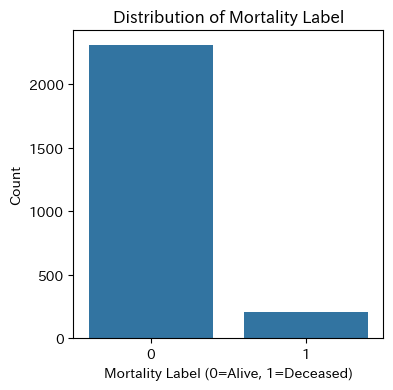

In [4]:
# @title 逝去あり/なしの分布, 欠損値や外れ値を含む全体のデータ概要を把握する

%matplotlib inline
# ---------------------------------------------
# 前提: df_merged をコピーして df に格納
# ---------------------------------------------
df = df_merged.copy()

# =============================================
# 1. 逝去あり/なしの分布の確認とクラス不均衡の評価
# =============================================
print("=== 逝去あり/なしの件数 ===")
mortality_counts = df['mortality_label'].value_counts()
print(mortality_counts)

# クラスの比率を算出し、少数クラスが全体の30%未満なら警告
total = mortality_counts.sum()
minority_ratio = (mortality_counts.min() / total) * 100
if minority_ratio < 30:
    print(f"Warning: クラス不均衡が見られます。少数クラスの比率は {minority_ratio:.2f}% です。")
else:
    print("クラス分布は比較的均衡しています。")

plt.figure(figsize=(4, 4))
sns.countplot(x='mortality_label', data=df)
plt.title("Distribution of Mortality Label")
plt.xlabel("Mortality Label (0=Alive, 1=Deceased)")
plt.ylabel("Count")
plt.show()

In [5]:
# =============================================
# 2. 欠損値の確認と欠損率に基づく警告
# =============================================
print("\n=== データフレームの基本情報 ===")
df.info()

print("\n=== 欠損値の総数 ===")
missing_counts = df.isnull().sum()
print(missing_counts)

missing_ratios = (df.isnull().sum() / len(df)) * 100
print("\n=== 欠損値の比率(%) ===")
print(missing_ratios)

# 例えば欠損率が20%以上のカラムがあれば警告を表示
missing_threshold = 20  # 20% を閾値とする
for col, ratio in missing_ratios.items():
    if ratio > missing_threshold:
        print(f"Warning: カラム '{col}' の欠損率は {ratio:.2f}% です。データ品質を再検討してください。")



=== データフレームの基本情報 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   patientunitstayid        2520 non-null   int64  
 1   hospitaldischargestatus  2520 non-null   object 
 2   age                      2520 non-null   int64  
 3   gender                   2520 non-null   object 
 4   admissionheight          2520 non-null   object 
 5   admissionweight          2520 non-null   object 
 6   hospitaladmittime24      2520 non-null   object 
 7   systemicsystolic         2520 non-null   float64
 8   systemicdiastolic        2520 non-null   float64
 9   heartrate                2520 non-null   float64
 10  temperature              2520 non-null   float64
 11  mean_creatinine          2520 non-null   float64
 12  mean_glucose             2520 non-null   float64
 13  max_creatinine           2520 non-null   float64
 14  ma

In [6]:
# =============================================
# 3. 全体の要約統計量 (数値カラム)
# =============================================
print("\n=== 数値カラムの基本統計量 (describe) ===")
df.describe()


=== 数値カラムの基本統計量 (describe) ===


,patientunitstayid,age,systemicsystolic,systemicdiastolic,heartrate,temperature,mean_creatinine,mean_glucose,max_creatinine,max_glucose,min_creatinine,min_glucose,mortality_label
count,2.520000e+03,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000
mean,1.666226e+06,59.680556,2.649627,0.835696,1.712470,0.234335,1.236033,134.388504,1.560503,184.792063,0.994188,101.788889,0.084127
std,1.022224e+06,20.892510,20.590385,10.488470,15.231658,7.055886,1.424804,74.837123,1.900515,140.605190,1.136954,57.571688,0.277633
min,1.417640e+05,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,7.722628e+05,50.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.709375,102.222222,0.800000,117.000000,0.600000,81.000000,0.000000
50%,1.590372e+06,64.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.956071,120.507576,1.100000,150.000000,0.800000,95.000000,0.000000
75%,2.697422e+06,76.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.357708,152.422727,1.700000,209.000000,1.100000,116.000000,0.000000
max,3.353113e+06,89.000000,204.993103,109.441379,110.246575,99.138820,13.920000,896.000000,20.200000,1453.000000,13.060000,896.000000,1.000000


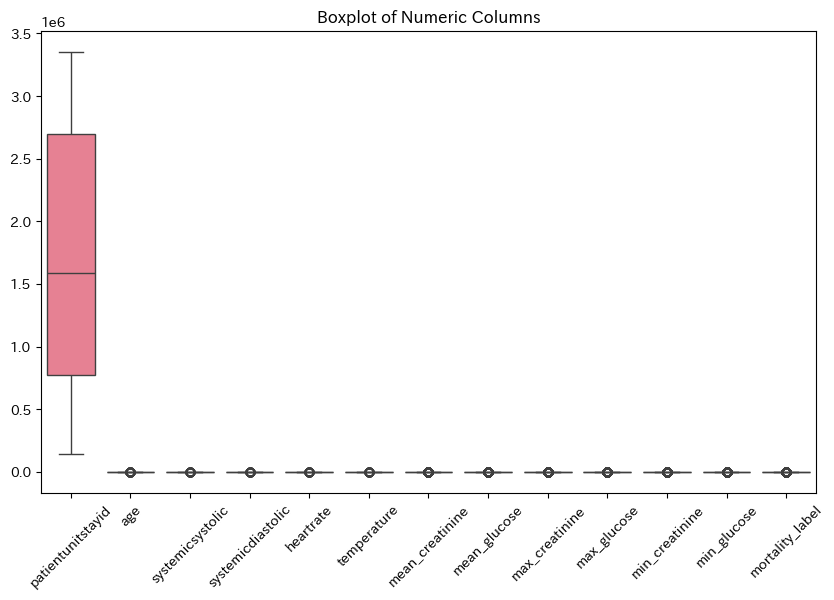


=== 外れ値の検出 (IQR法) ===
カラム 'patientunitstayid': 外れ値の比率は 0.00% です。
カラム 'age': 外れ値の比率は 4.05% です。
カラム 'systemicsystolic': 外れ値の比率は 3.13% です。
カラム 'systemicdiastolic': 外れ値の比率は 3.13% です。
カラム 'heartrate': 外れ値の比率は 3.13% です。
カラム 'temperature': 外れ値の比率は 3.13% です。
カラム 'mean_creatinine': 外れ値の比率は 15.83% です。
カラム 'mean_glucose': 外れ値の比率は 14.44% です。
カラム 'max_creatinine': 外れ値の比率は 16.15% です。
カラム 'max_glucose': 外れ値の比率は 8.57% です。
カラム 'min_creatinine': 外れ値の比率は 15.12% です。
カラム 'min_glucose': 外れ値の比率は 14.21% です。
カラム 'mortality_label': 外れ値の比率は 8.41% です。


In [7]:
# =============================================
# 4. 外れ値確認のための可視化と自動判定 (IQR法)
# =============================================
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_cols) > 0:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[numeric_cols])
    plt.xticks(rotation=45)
    plt.title("Boxplot of Numeric Columns")
    plt.show()
else:
    print("\n=== 数値カラムが存在しないため、Boxplotはスキップ ===")

print("\n=== 外れ値の検出 (IQR法) ===")
# 各数値カラムについて、IQR法で外れ値の比率を算出
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outlier_mask.sum()
    outlier_ratio = (outlier_count / len(df)) * 100
    print(f"カラム '{col}': 外れ値の比率は {outlier_ratio:.2f}% です。")
    if outlier_ratio > 5:
        print(f"  Warning: カラム '{col}' には外れ値が多い可能性があります。")

In [8]:
# =============================================
# 5. 判定結果に基づくまとめコメント（例）
# =============================================
print("\n=== 判定結果のまとめ ===")
if minority_ratio < 30:
    print("・クラス不均衡が懸念されます。特に少数クラスのサンプルが少ないため、オーバーサンプリングやクラス重みの調整を検討してください。")
for col, ratio in missing_ratios.items():
    if ratio > missing_threshold:
        print(f"・カラム '{col}' の欠損値が多いため、データ補完やカラムの除外を検討してください。")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outlier_mask.sum()
    outlier_ratio = (outlier_count / len(df)) * 100
    if outlier_ratio > 5:
        print(f"・カラム '{col}' の外れ値が {outlier_ratio:.2f}% と多いため、外れ値処理を検討してください。")



=== 判定結果のまとめ ===
・クラス不均衡が懸念されます。特に少数クラスのサンプルが少ないため、オーバーサンプリングやクラス重みの調整を検討してください。
・カラム 'mean_creatinine' の外れ値が 15.83% と多いため、外れ値処理を検討してください。
・カラム 'mean_glucose' の外れ値が 14.44% と多いため、外れ値処理を検討してください。
・カラム 'max_creatinine' の外れ値が 16.15% と多いため、外れ値処理を検討してください。
・カラム 'max_glucose' の外れ値が 8.57% と多いため、外れ値処理を検討してください。
・カラム 'min_creatinine' の外れ値が 15.12% と多いため、外れ値処理を検討してください。
・カラム 'min_glucose' の外れ値が 14.21% と多いため、外れ値処理を検討してください。
・カラム 'mortality_label' の外れ値が 8.41% と多いため、外れ値処理を検討してください。



=== 欠損率が多い項目 ===
Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []


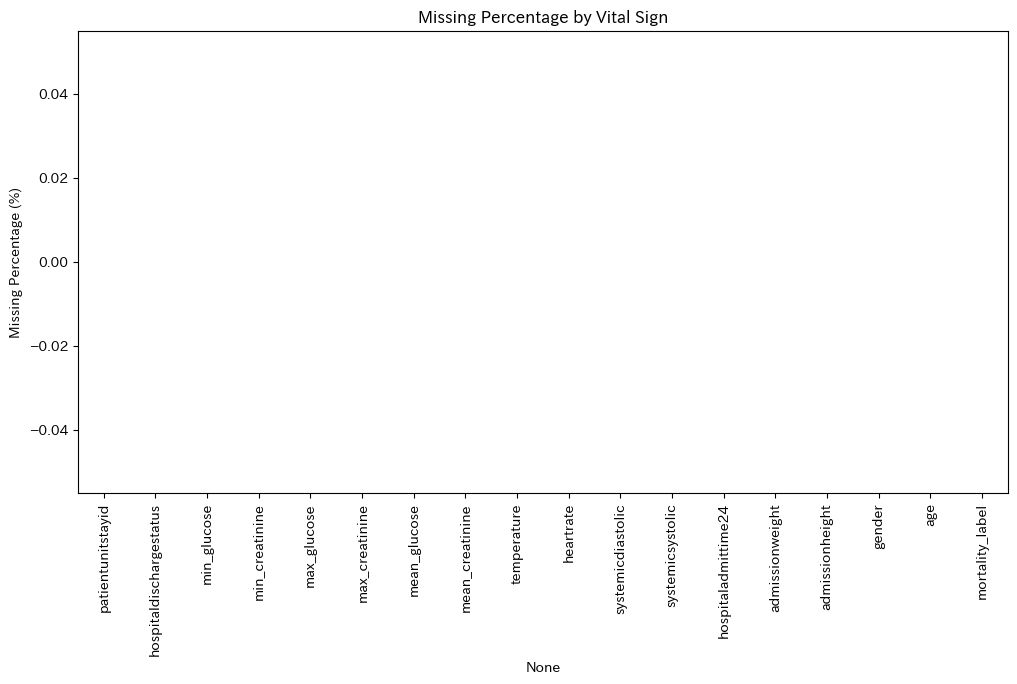

In [9]:
# @title バイタル測定漏れや記録漏れの多い項目を特定し、原因を仮説立てする

# --------------------------------------------------
# 前提: df_merged をコピーして df_vitals とする
# --------------------------------------------------
df_vitals = df_merged.copy()

# =============================================
# 1. 各バイタル項目の欠損率を計算
# =============================================
missing_data = df_vitals.isnull().sum()            # 各カラムの欠損数
missing_percentage = (missing_data / len(df_vitals)) * 100  # 欠損率 (%)
missing_summary = pd.DataFrame({
    'missing_count': missing_data,
    'missing_percentage': missing_percentage
})
missing_summary = missing_summary.sort_values(by='missing_percentage', ascending=False)

print("\n=== 欠損率が多い項目 ===")
print(missing_summary[missing_summary['missing_percentage'] > 0])

# 例として、欠損率が30%以上の項目がある場合に警告を出す
missing_threshold = 30.0
for col, row in missing_summary.iterrows():
    if row['missing_percentage'] > missing_threshold:
        print(f"【警告】カラム '{col}' の欠損率は {row['missing_percentage']:.2f}% です。測定漏れや記録漏れが疑われます。")

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_summary.index, y=missing_summary['missing_percentage'])
plt.xticks(rotation=90)
plt.ylabel("Missing Percentage (%)")
plt.title("Missing Percentage by Vital Sign")
plt.show()


In [10]:
# =============================================
# 2. 欠損値の原因仮説を立てるためのデータ探索
# =============================================

# 2-1. ICU滞在時間と欠損数の関係
if 'stay_duration' in df_vitals.columns:
    # 行ごとの欠損数を計算（全カラムでの欠損数）
    df_vitals['row_missing_count'] = df_vitals.isnull().sum(axis=1)
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_vitals, x='row_missing_count', y='stay_duration')
    plt.title("Missing Count vs. ICU Stay Duration")
    plt.xlabel("Missing Count per Row")
    plt.ylabel("ICU Stay Duration")
    plt.show()

    # 仮説例: ICU滞在時間が短い患者は十分な測定が行われず、欠損が多い可能性
    median_missing = df_vitals.groupby('stay_duration')['row_missing_count'].median().median()
    print(f"全体のICU滞在時間に対する欠損数の中央値は {median_missing:.2f} です。短い滞在の場合、測定漏れが疑われます。")

# 2-2. 測定機器 (device_type) 別の欠損状況
if 'device_type' in df_vitals.columns:
    missing_by_device = df_vitals.groupby('device_type').apply(lambda x: x.isnull().sum())
    print("\n=== デバイス別の欠損数 ===")
    print(missing_by_device)

    # 各デバイスでの欠損率を算出し、高い場合は警告を出す
    device_missing_ratio = df_vitals.groupby('device_type').apply(lambda x: (x.isnull().sum()/len(x))*100)
    for device, missing_rates in device_missing_ratio.iterrows():
        max_rate = missing_rates.max()
        if max_rate > missing_threshold:
            print(f"【警告】デバイス '{device}' では、欠損率が {max_rate:.2f}% と高いため、機器の設定や故障の可能性があります。")


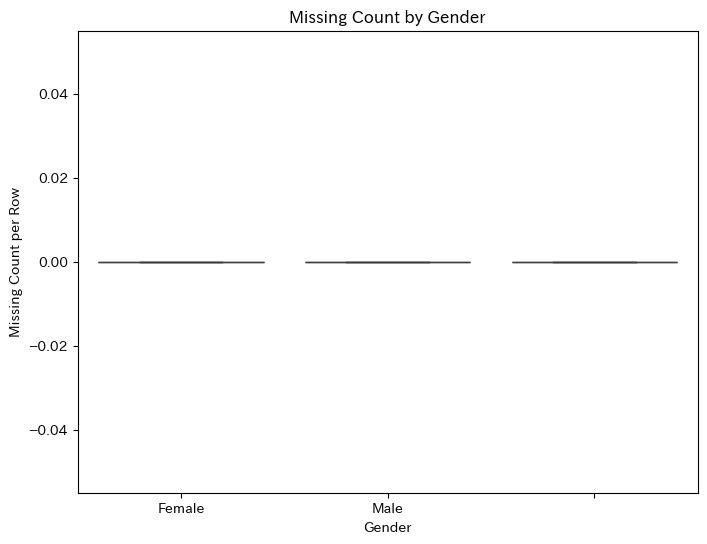


=== 性別ごとの中央値の欠損数 ===
gender
          0.0
Female    0.0
Male      0.0
Name: row_missing_count, dtype: float64


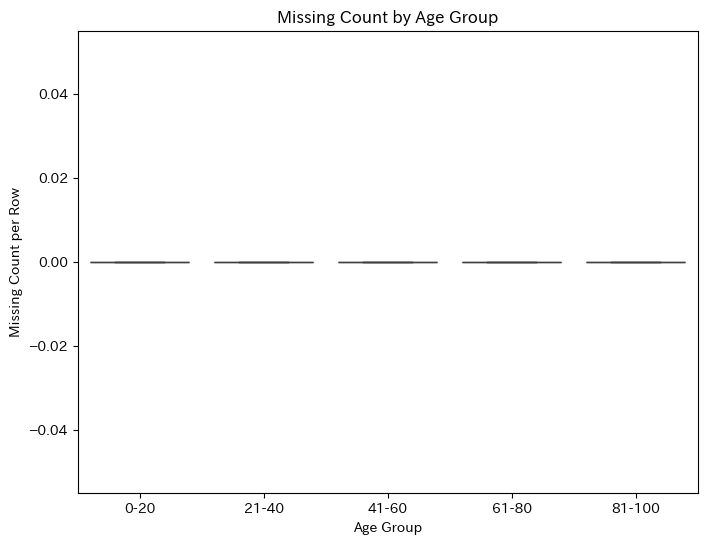


=== 年齢層ごとの中央値の欠損数 ===
age_group
0-20      0.0
21-40     0.0
41-60     0.0
61-80     0.0
81-100    0.0
Name: row_missing_count, dtype: float64


<ipython-input-11-6bebf7fb761f>:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_by_age = df_vitals.groupby('age_group')['row_missing_count'].median()


In [11]:
# =============================================
# 3. 特定項目の欠損分布を患者属性別に調べる
# =============================================
# 3-1. 性別ごとの欠損状況
if 'gender' in df_vitals.columns:
    # すでに 'row_missing_count' が計算されていれば利用
    if 'row_missing_count' not in df_vitals.columns:
        df_vitals['row_missing_count'] = df_vitals.isnull().sum(axis=1)
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_vitals, x='gender', y='row_missing_count')
    plt.title("Missing Count by Gender")
    plt.xlabel("Gender")
    plt.ylabel("Missing Count per Row")
    plt.show()

    missing_by_gender = df_vitals.groupby('gender')['row_missing_count'].median()
    print("\n=== 性別ごとの中央値の欠損数 ===")
    print(missing_by_gender)
    # 仮説: ある性別で欠損が著しく多い場合、測定手順や記録の偏りが考えられる

# 3-2. 年齢層ごとの欠損状況
if 'age' in df_vitals.columns:
    age_bins = pd.cut(df_vitals['age'], bins=[0, 20, 40, 60, 80, 100], labels=["0-20", "21-40", "41-60", "61-80", "81-100"])
    df_vitals['age_group'] = age_bins
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_vitals, x='age_group', y='row_missing_count')
    plt.title("Missing Count by Age Group")
    plt.xlabel("Age Group")
    plt.ylabel("Missing Count per Row")
    plt.show()

    missing_by_age = df_vitals.groupby('age_group')['row_missing_count'].median()
    print("\n=== 年齢層ごとの中央値の欠損数 ===")
    print(missing_by_age)
    # 仮説: 高齢者など特定の年齢層で測定が難しい可能性がある場合、欠損が多くなるかもしれません。



In [12]:
# =============================================
# 4. まとめ: 仮説の提示
# =============================================
print("\n=== 判定結果のまとめ ===")
if missing_summary['missing_percentage'].max() > missing_threshold:
    print("・一部のバイタル項目で欠損率が高く、測定漏れや記録漏れが疑われます。")
else:
    print("・欠損率は全体的に許容範囲内です。")

if 'stay_duration' in df_vitals.columns:
    print("・ICU滞在時間が短い患者で欠損数が増加している場合、短期入室のため測定タイミングが合わない可能性があります。")
if 'device_type' in df_vitals.columns:
    print("・特定の測定機器で欠損率が高い場合、機器の不具合や設定ミスが考えられます。")
if 'gender' in df_vitals.columns or 'age_group' in df_vitals.columns:
    print("・性別や年齢層で欠損分布に偏りが認められる場合、特定の患者属性における測定困難性や記録漏れが影響している可能性があります。")



=== 判定結果のまとめ ===
・欠損率は全体的に許容範囲内です。
・性別や年齢層で欠損分布に偏りが認められる場合、特定の患者属性における測定困難性や記録漏れが影響している可能性があります。


In [13]:
# @title バイタル値における生理学的にあり得ない値や連続的に記録が途切れているケースを洗い出す
import pandas as pd
import numpy as np

# 例: バイタルデータを含むデータフレーム df_vitals を用意済みと仮定
# df_vitals = pd.read_csv("path/to/vital_data.csv")
# ここでは df_merged をコピーして利用する例です。
df_vitals = df_merged.copy()

# --------------------------------------------------
# 1. 生理学的にあり得ない値の洗い出し
# --------------------------------------------------
# 各バイタル項目の生理学的に許容される値の範囲を定義
physiological_limits = {
    "heart_rate": (30, 220),       # 心拍数の正常範囲
    "blood_pressure": (40, 250),   # 血圧 (収縮期)
    "spo2": (50, 100),             # 酸素飽和度 (%)
    "temperature": (30, 45)        # 体温 (°C)
}

# 各項目について、生理学的範囲外の値を検出し、フラグを付与
for col, (min_val, max_val) in physiological_limits.items():
    if col in df_vitals.columns:
        df_vitals[f"{col}_out_of_range"] = ~df_vitals[col].between(min_val, max_val)

# 生理学的に範囲外の値が何件あるかをまとめる
out_of_range_summary = {
    col: df_vitals[f"{col}_out_of_range"].sum()
    for col in physiological_limits if col in df_vitals.columns
}
print("\n=== 生理学的に外れる値の件数 ===")
print(out_of_range_summary)


=== 生理学的に外れる値の件数 ===
{'temperature': 2443}


In [14]:
df_vitals.columns

Index(['patientunitstayid', 'hospitaldischargestatus', 'age', 'gender',
       'admissionheight', 'admissionweight', 'hospitaladmittime24',
       'systemicsystolic', 'systemicdiastolic', 'heartrate', 'temperature',
       'mean_creatinine', 'mean_glucose', 'max_creatinine', 'max_glucose',
       'min_creatinine', 'min_glucose', 'mortality_label',
       'temperature_out_of_range'],
      dtype='object')

In [15]:
# --------------------------------------------------
# 2. 連続記録の途切れ確認
# --------------------------------------------------
# 測定タイムスタンプの列名を指定 (例: "timestamp")
time_col = "timestamp"
# 連続して記録されているとみなす時間間隔の閾値（例: 5分）
time_threshold = pd.Timedelta(minutes=5)

if time_col in df_vitals.columns:
    # タイムスタンプを datetime 型に変換
    df_vitals[time_col] = pd.to_datetime(df_vitals[time_col])
    # 各行のタイムスタンプ差分を計算
    df_vitals["time_diff"] = df_vitals[time_col].diff()
    # タイムスタンプの差分が閾値を超える場合に「記録途切れ」と判断しフラグを付与
    df_vitals["is_disrupted"] = df_vitals["time_diff"] > time_threshold
    # 途切れたケース数を表示
    disruptions = df_vitals["is_disrupted"].sum()
    print("\n=== 連続記録の途切れ件数 ===")
    print(f"途切れた回数: {disruptions}")



=== 生理学的に外れる値があるデータ ===
      patientunitstayid hospitaldischargestatus  age  gender admissionheight  \
0                141764                   Alive   87  Female           157.5   
1                141765                   Alive   87  Female           157.5   
2                143870                   Alive   76    Male             167   
3                144815                   Alive   34  Female           172.7   
4                145427                   Alive   61    Male           177.8   
...                 ...                     ...  ...     ...             ...   
2514            3351297                   Alive   52    Male             159   
2515            3351763                   Alive   62  Female           165.1   
2517            3352231                   Alive   41    Male           177.8   
2518            3352333                   Alive   72    Male           177.8   
2519            3353113                   Alive   50    Male             188   

     admission

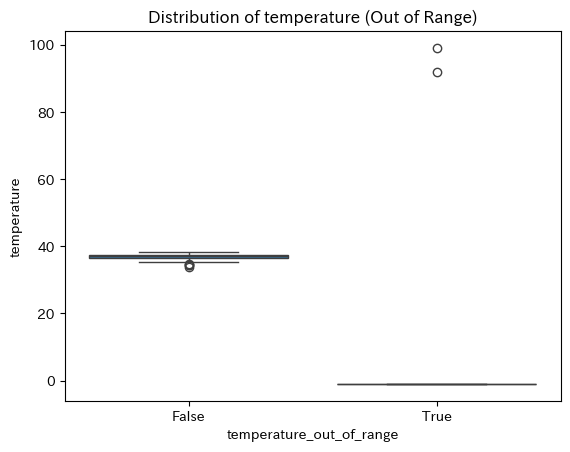


=== 生理学的に外れる値の件数 ===
{'temperature': 2443}

=== 生理学的に外れる値があるデータ ===
      patientunitstayid hospitaldischargestatus  age  gender admissionheight  \
0                141764                   Alive   87  Female           157.5   
1                141765                   Alive   87  Female           157.5   
2                143870                   Alive   76    Male             167   
3                144815                   Alive   34  Female           172.7   
4                145427                   Alive   61    Male           177.8   
...                 ...                     ...  ...     ...             ...   
2514            3351297                   Alive   52    Male             159   
2515            3351763                   Alive   62  Female           165.1   
2517            3352231                   Alive   41    Male           177.8   
2518            3352333                   Alive   72    Male           177.8   
2519            3353113                   Alive   5

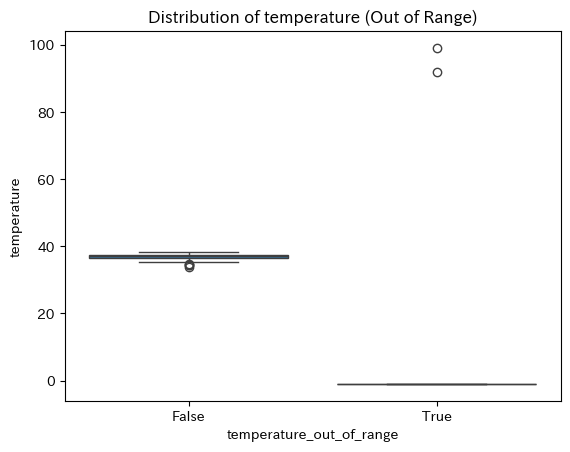

In [16]:

# --------------------------------------------------
# 3. レポートの出力
# --------------------------------------------------
# 生理学的に範囲外の値が含まれる行を抽出
out_of_range_rows = df_vitals.loc[
    df_vitals[[f"{col}_out_of_range" for col in physiological_limits if f"{col}_out_of_range" in df_vitals.columns]].any(axis=1)
]
print("\n=== 生理学的に外れる値があるデータ ===")
print(out_of_range_rows)

# 連続記録が途切れている行を抽出 (タイムスタンプ列が存在する場合)
if time_col in df_vitals.columns:
    disrupted_rows = df_vitals[df_vitals["is_disrupted"]]
    print("\n=== 連続記録が途切れているデータ ===")
    print(disrupted_rows)

# --------------------------------------------------
# 4. 可視化 (オプション)
# --------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# 各バイタル項目について、範囲外フラグとともに値の分布を boxplot で可視化
for col in physiological_limits:
    if col in df_vitals.columns:
        sns.boxplot(data=df_vitals, x=f"{col}_out_of_range", y=col)
        plt.title(f"Distribution of {col} (Out of Range)")
        plt.show()

import pandas as pd
import numpy as np

# 例: バイタルデータを含むデータフレーム df_vitals を想定
# df_vitals = pd.read_csv("path/to/vital_data.csv")

df_vitals = df_merged.copy()

# --------------------------------------------------
# 1. 生理学的にあり得ない値の洗い出し
# --------------------------------------------------

# 値の範囲を定義 (例: 心拍数, 血圧, 酸素飽和度など)
physiological_limits = {
    "heart_rate": (30, 220),       # 心拍数の正常範囲
    "blood_pressure": (40, 250),  # 血圧 (収縮期)
    "spo2": (50, 100),            # 酸素飽和度 (%)
    "temperature": (30, 45)       # 体温 (°C)
}

# 生理学的に外れる値を検出し、フラグ付け
for col, (min_val, max_val) in physiological_limits.items():
    if col in df_vitals.columns:
        df_vitals[f"{col}_out_of_range"] = ~df_vitals[col].between(min_val, max_val)

# 生理学的に外れる値の件数を表示
out_of_range_summary = {
    col: df_vitals[f"{col}_out_of_range"].sum() for col in physiological_limits if col in df_vitals.columns
}
print("\n=== 生理学的に外れる値の件数 ===")
print(out_of_range_summary)

# --------------------------------------------------
# 2. 連続記録の途切れ確認
# --------------------------------------------------

# 測定タイムスタンプの間隔 (例: 5分未満なら途切れていないとみなす)
time_col = "timestamp"  # 測定タイムスタンプ列名
time_threshold = pd.Timedelta(minutes=5)

if time_col in df_vitals.columns:
    # タイムスタンプをdatetime型に変換
    df_vitals[time_col] = pd.to_datetime(df_vitals[time_col])

    # タイムスタンプの差分を計算
    df_vitals["time_diff"] = df_vitals[time_col].diff()

    # 記録が途切れているかフラグ付け
    df_vitals["is_disrupted"] = df_vitals["time_diff"] > time_threshold

    # 途切れたケースの件数を表示
    disruptions = df_vitals["is_disrupted"].sum()
    print("\n=== 連続記録の途切れ件数 ===")
    print(f"途切れた回数: {disruptions}")

# --------------------------------------------------
# 3. レポートの出力
# --------------------------------------------------

# 生理学的に外れる値がある行を抽出
out_of_range_rows = df_vitals.loc[
    df_vitals[[f"{col}_out_of_range" for col in physiological_limits if f"{col}_out_of_range" in df_vitals.columns]].any(axis=1)
]

print("\n=== 生理学的に外れる値があるデータ ===")
print(out_of_range_rows)

# 連続記録が途切れている行を抽出
if time_col in df_vitals.columns:
    disrupted_rows = df_vitals[df_vitals["is_disrupted"]]
    print("\n=== 連続記録が途切れているデータ ===")
    print(disrupted_rows)

# --------------------------------------------------
# 4. 可視化 (オプション)
# --------------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# 生理学的範囲外のデータを可視化
for col in physiological_limits:
    if col in df_vitals.columns:
        sns.boxplot(data=df_vitals, x=f"{col}_out_of_range", y=col)
        plt.title(f"Distribution of {col} (Out of Range)")
        plt.show()


<ipython-input-17-7a17d0afa12e>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_column] = pd.to_datetime(df[time_column])


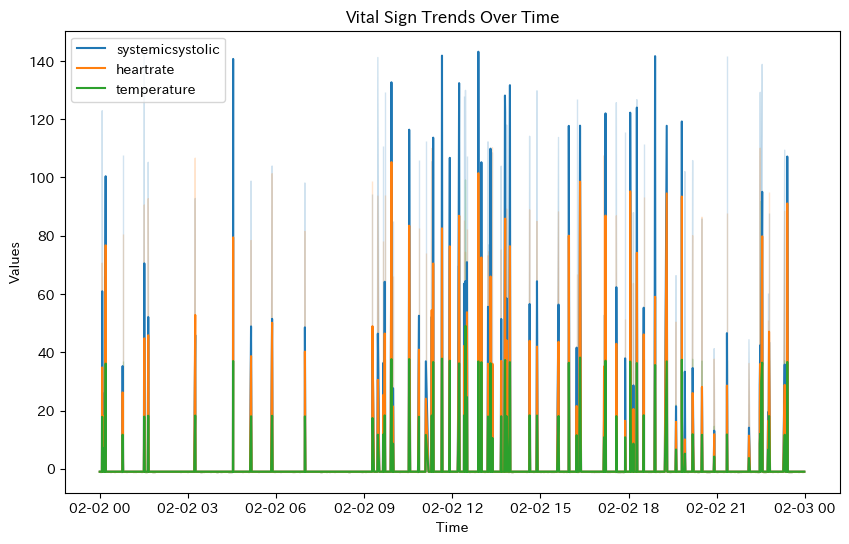

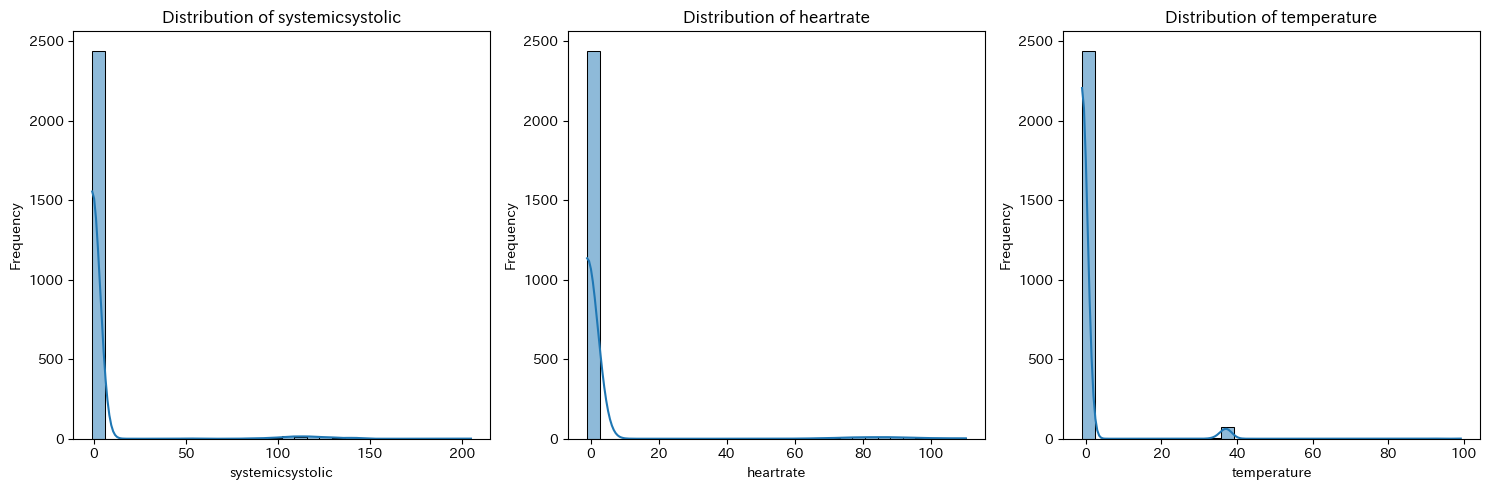

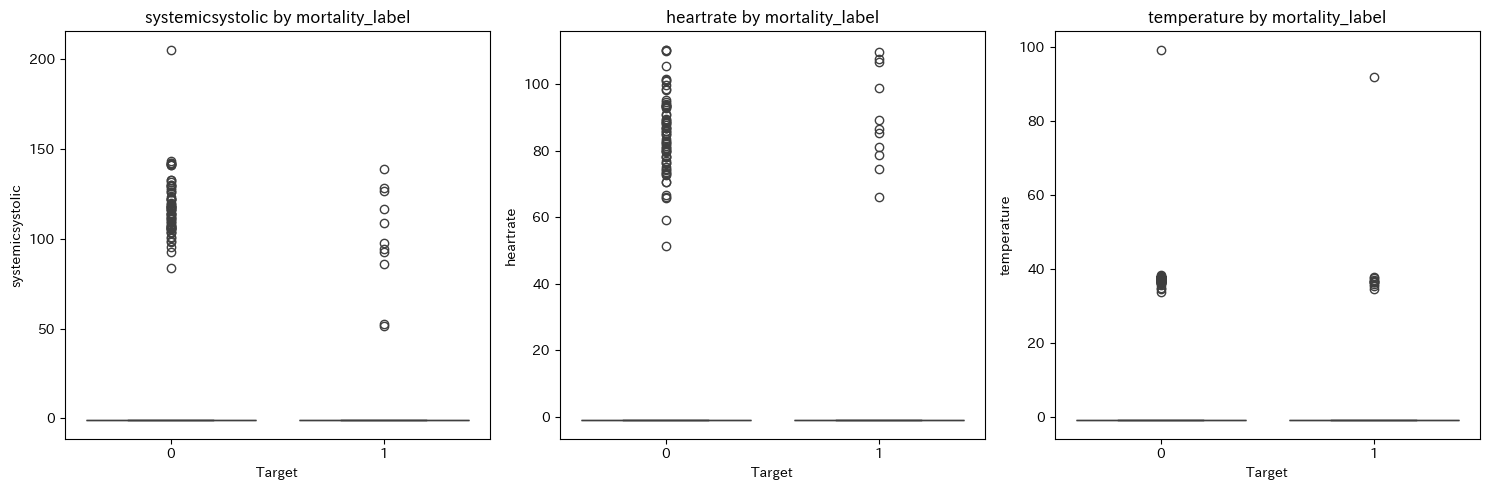

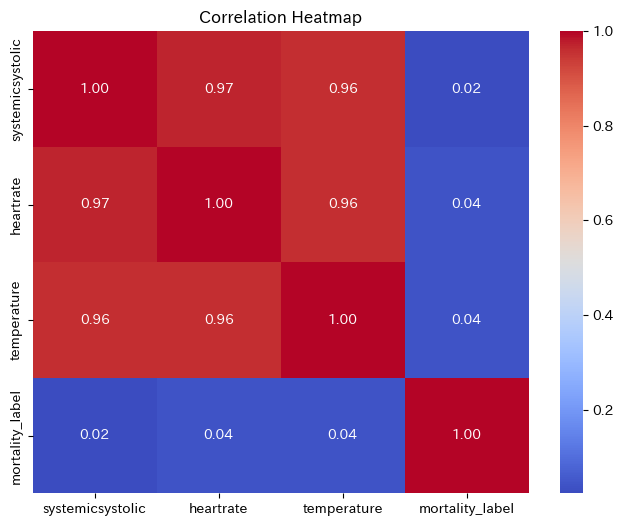

In [17]:
# @title 血圧, 脈拍, 体温などの時系列推移や分布を可視化して、ターゲットとの関連を見極める（未完成）

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. データの準備
# --------------------------------------------------
# df_merged をコピーして df として利用（実際にはデータを読み込む処理などを行ってください）
df = df_merged.copy()

# 必要なカラムの設定
time_column = "hospitaladmittime24"  # 時間列（例：入院時刻）
vital_columns = ["systemicsystolic", "heartrate", "temperature"]  # 血圧（収縮期）、脈拍、体温
target_column = "mortality_label"  # ターゲット変数（例：0=Alive, 1=Deceased）

# タイムスタンプを datetime 型に変換
df[time_column] = pd.to_datetime(df[time_column])

# 必要なカラムが存在するかチェック
required_columns = [time_column] + vital_columns + [target_column]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"以下のカラムがデータに存在しません: {missing_columns}")

# --------------------------------------------------
# 2. 時系列推移の可視化
# --------------------------------------------------
plt.figure(figsize=(10, 6))
for vital in vital_columns:
    sns.lineplot(data=df, x=time_column, y=vital, label=vital)
plt.title("Vital Sign Trends Over Time")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()

# --------------------------------------------------
# 3. 各バイタル指標の分布可視化
# --------------------------------------------------
plt.figure(figsize=(15, 5))
for i, vital in enumerate(vital_columns, 1):
    plt.subplot(1, len(vital_columns), i)
    sns.histplot(data=df, x=vital, kde=True, bins=30)
    plt.title(f"Distribution of {vital}")
    plt.xlabel(vital)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 4. ターゲット別の分布比較
# --------------------------------------------------
plt.figure(figsize=(15, 5))
for i, vital in enumerate(vital_columns, 1):
    plt.subplot(1, len(vital_columns), i)
    sns.boxplot(data=df, x=target_column, y=vital)
    plt.title(f"{vital} by {target_column}")
    plt.xlabel("Target")
    plt.ylabel(vital)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 5. 相関関係のヒートマップ
# --------------------------------------------------
# ターゲットとバイタル指標の相関係数を計算
correlation_data = df[vital_columns + [target_column]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 特徴量エンジニアリング

In [18]:
df_merged.head()

,patientunitstayid,hospitaldischargestatus,age,gender,admissionheight,admissionweight,hospitaladmittime24,systemicsystolic,systemicdiastolic,heartrate,temperature,mean_creatinine,mean_glucose,max_creatinine,max_glucose,min_creatinine,min_glucose,mortality_label
0,141764,Alive,87,Female,157.5,,23:36:00,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00,-1.0,-1.00,-1.0,0
1,141765,Alive,87,Female,157.5,46.5,23:36:00,-1.0,-1.0,-1.0,-1.0,1.070000,77.0,1.32,91.0,0.85,61.0,0
2,143870,Alive,76,Male,167,77.5,20:46:00,-1.0,-1.0,-1.0,-1.0,1.015000,131.5,1.14,140.0,0.89,123.0,0
3,144815,Alive,34,Female,172.7,60.3,01:44:00,-1.0,-1.0,-1.0,-1.0,0.690000,90.5,0.75,99.0,0.63,82.0,0
4,145427,Alive,61,Male,177.8,91.7,23:48:00,-1.0,-1.0,-1.0,-1.0,1.123333,128.5,1.20,139.0,1.05,118.0,0


In [19]:
# @title カテゴリデータをラベルエンコーディング/ワンホット化する

import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# --------------------------------------------------
# データフレーム (eICUデータ) の例を想定
# --------------------------------------------------
# df_merged = ...  # 先ほどのコードで取得したデータフレーム

# カテゴリデータの例 (実際のカラム名に応じて変更)
categorical_columns = ["gender", "hospitaldischargestatus"]  # カテゴリデータを含むカラム名

# --------------------------------------------------
# 1. ラベルエンコーディング
# --------------------------------------------------
# 各カテゴリ列をラベルエンコーディング
label_encoded_df = df_merged.copy()
label_encoders = {}  # 各カラムのLabelEncoderを保持

for col in categorical_columns:
    label_encoder = LabelEncoder()
    df_merged[col] = label_encoder.fit_transform(df_merged[col].astype(str))
    label_encoders[col] = label_encoder  # エンコーダを保存

# ラベルエンコーディング結果を確認
print("=== ラベルエンコーディング後 ===")
print(df_merged[categorical_columns].head())

# --------------------------------------------------
# 2. ワンホットエンコーディング
# --------------------------------------------------
# ワンホットエンコーディングを適用
one_hot_encoded_df = pd.get_dummies(df_merged, columns=categorical_columns)

# ワンホットエンコーディング結果を確認
print("=== ワンホットエンコーディング後 ===")
print(one_hot_encoded_df.head())

# --------------------------------------------------
# 必要に応じて元データをラベルエンコーディング/ワンホット化したデータに置き換え
# --------------------------------------------------
# 特徴量をラベルエンコーディング版で更新
X_label_encoded = df_merged.drop(["mortality_label"], axis=1)
y = df_merged["mortality_label"]

# 特徴量をワンホットエンコーディング版で更新
X_one_hot_encoded = one_hot_encoded_df.drop(["mortality_label"], axis=1)

# ラベルをそのまま保持
y_one_hot = one_hot_encoded_df["mortality_label"]


=== ラベルエンコーディング後 ===
   gender  hospitaldischargestatus
0       1                        1
1       1                        1
2       2                        1
3       1                        1
4       2                        1
=== ワンホットエンコーディング後 ===
   patientunitstayid  age admissionheight admissionweight hospitaladmittime24  \
0             141764   87           157.5                            23:36:00   
1             141765   87           157.5            46.5            23:36:00   
2             143870   76             167            77.5            20:46:00   
3             144815   34           172.7            60.3            01:44:00   
4             145427   61           177.8            91.7            23:48:00   

   systemicsystolic  systemicdiastolic  heartrate  temperature  \
0              -1.0               -1.0       -1.0         -1.0   
1              -1.0               -1.0       -1.0         -1.0   
2              -1.0               -1.0       -1.0         -1.

In [20]:
# @title バイタル値や行動量など数値データのスケールを揃え、学習効率を向上させる

import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# --------------------------------------------------
# データフレーム (eICUデータ) の例を想定
# --------------------------------------------------
# df_merged = ...  # 先ほどのコードで取得したデータフレーム
# ここでは df_merged がすでに存在している前提とします。

# カテゴリデータの例 (実際のカラム名に応じて変更)
categorical_columns = ["gender", "hospitaldischargestatus"]  # カテゴリデータを含むカラム名

# --------------------------------------------------
# 1. ラベルエンコーディング
# --------------------------------------------------
# 各カテゴリ列をラベルエンコーディングするためのコピーを作成
label_encoded_df = df_merged.copy()
label_encoders = {}  # 各カラムの LabelEncoder を保持するための辞書

for col in categorical_columns:
    label_encoder = LabelEncoder()
    # カラムの値を文字列型に変換した上でエンコード
    label_encoded_df[col] = label_encoder.fit_transform(label_encoded_df[col].astype(str))
    label_encoders[col] = label_encoder  # エンコーダを保存

# ラベルエンコーディング結果を確認
print("=== ラベルエンコーディング後 ===")
print(label_encoded_df[categorical_columns].head())

# --------------------------------------------------
# 2. ワンホットエンコーディング
# --------------------------------------------------
# ラベルエンコーディング版を元に、pd.get_dummies() を使用してワンホットエンコーディングを実施
one_hot_encoded_df = pd.get_dummies(label_encoded_df, columns=categorical_columns)

# ワンホットエンコーディング結果を確認
print("=== ワンホットエンコーディング後 ===")
print(one_hot_encoded_df.head())

# --------------------------------------------------
# 必要に応じて元データをエンコーディング済みのデータに置き換え
# --------------------------------------------------
# ターゲット変数 mortality_label を除いた特徴量を用意 (ラベルエンコーディング版)
X_label_encoded = label_encoded_df.drop(["mortality_label"], axis=1)
y = label_encoded_df["mortality_label"]

# ワンホットエンコーディング版の場合
X_one_hot_encoded = one_hot_encoded_df.drop(["mortality_label"], axis=1)
y_one_hot = one_hot_encoded_df["mortality_label"]



=== ラベルエンコーディング後 ===
   gender  hospitaldischargestatus
0       1                        1
1       1                        1
2       2                        1
3       1                        1
4       2                        1
=== ワンホットエンコーディング後 ===
   patientunitstayid  age admissionheight admissionweight hospitaladmittime24  \
0             141764   87           157.5                            23:36:00   
1             141765   87           157.5            46.5            23:36:00   
2             143870   76             167            77.5            20:46:00   
3             144815   34           172.7            60.3            01:44:00   
4             145427   61           177.8            91.7            23:48:00   

   systemicsystolic  systemicdiastolic  heartrate  temperature  \
0              -1.0               -1.0       -1.0         -1.0   
1              -1.0               -1.0       -1.0         -1.0   
2              -1.0               -1.0       -1.0         -1.

In [21]:
# @title 年齢や既往歴から個別のリスクスコアを推定し特徴量化（未完成）

import pandas as pd
import numpy as np

# --------------------------------------------------
# 1. サンプルデータフレームの作成 (年齢と既往歴)
# --------------------------------------------------
# ※実際のeICUデータに置き換えてください
df_merged = pd.DataFrame({
    "patientunitstayid": [1, 2, 3, 4, 5],
    "age": [45, 70, 25, 55, 85],
    "has_hypertension": [1, 1, 0, 0, 1],   # 高血圧
    "has_diabetes": [0, 1, 0, 1, 1],         # 糖尿病
    "has_smoking_history": [1, 0, 1, 1, 0]    # 喫煙歴
})

# --------------------------------------------------
# 2. リスクスコア設計
# --------------------------------------------------
# 年齢ごとのリスクスコア
def calculate_age_risk(age):
    if age < 30:
        return 1
    elif age < 50:
        return 2
    elif age < 70:
        return 3
    else:
        return 4

# 既往歴のリスクウェイト（各既往歴が与えるリスク値）
condition_weights = {
    "has_hypertension": 2,   # 高血圧: 重み2
    "has_diabetes": 3,       # 糖尿病: 重み3
    "has_smoking_history": 1 # 喫煙歴: 重み1
}

# --------------------------------------------------
# 3. リスクスコアの計算
# --------------------------------------------------
# 年齢リスクの計算
df_merged["age_risk"] = df_merged["age"].apply(calculate_age_risk)

# 既往歴リスクの計算: 各既往歴の有無に応じた重みの総和を計算
df_merged["condition_risk"] = df_merged[list(condition_weights.keys())].apply(
    lambda row: sum(row[col] * weight for col, weight in condition_weights.items()),
    axis=1
)

# 総リスクスコア = 年齢リスク + 既往歴リスク
df_merged["total_risk_score"] = df_merged["age_risk"] + df_merged["condition_risk"]

# --------------------------------------------------
# 4. 結果の確認（リスクスコアの算出結果）
# --------------------------------------------------
print("=== リスクスコア計算結果 ===")
print(df_merged[["patientunitstayid", "age", "age_risk", "condition_risk", "total_risk_score"]])

# 例として、サンプルデータの場合
# 患者1: age=45 → age_risk=2, condition_risk=(高血圧2 + 喫煙歴1)=3, 合計=5
# 患者2: age=70 → age_risk=4, condition_risk=(高血圧2 + 糖尿病3)=5, 合計=9
# 患者3: age=25 → age_risk=1, condition_risk=(喫煙歴1)=1, 合計=2
# 患者4: age=55 → age_risk=3, condition_risk=(糖尿病3 + 喫煙歴1)=4, 合計=7
# 患者5: age=85 → age_risk=4, condition_risk=(高血圧2 + 糖尿病3)=5, 合計=9

# --------------------------------------------------
# 5. 特徴量として利用 (機械学習用)
# --------------------------------------------------
# 今回は総リスクスコアを特徴量として利用
X = df_merged[["total_risk_score"]]
y = None  # ターゲット変数は実際の用途に応じて設定

# --------------------------------------------------
# 6. 結果の判断と解釈
# --------------------------------------------------
# 以下は、総リスクスコアに基づいてリスクレベルを判定するための簡易なルール例です。
# ※閾値は用途やデータに応じて適宜調整してください。
def risk_level(score):
    if score <= 3:
        return "低リスク"
    elif score <= 6:
        return "中リスク"
    else:
        return "高リスク"

# 各患者のリスクレベルを計算して新たなカラムに追加
df_merged["risk_level"] = df_merged["total_risk_score"].apply(risk_level)

print("\n=== 個別のリスクスコアとリスクレベル ===")
print(df_merged[["patientunitstayid", "age", "total_risk_score", "risk_level"]])

# 出力結果の判断方法の説明
print("\n【解釈のガイドライン】")
print("・低リスク：総リスクスコアが3以下。継続的なモニタリングを推奨。")
print("・中リスク：総リスクスコアが4〜6。適度なフォローアップが必要。")
print("・高リスク：総リスクスコアが7以上。詳細な評価と積極的な介入を検討すべき。")


=== リスクスコア計算結果 ===
   patientunitstayid  age  age_risk  condition_risk  total_risk_score
0                  1   45         2               3                 5
1                  2   70         4               5                 9
2                  3   25         1               1                 2
3                  4   55         3               4                 7
4                  5   85         4               5                 9

=== 個別のリスクスコアとリスクレベル ===
   patientunitstayid  age  total_risk_score risk_level
0                  1   45                 5       中リスク
1                  2   70                 9       高リスク
2                  3   25                 2       低リスク
3                  4   55                 7       高リスク
4                  5   85                 9       高リスク

【解釈のガイドライン】
・低リスク：総リスクスコアが3以下。継続的なモニタリングを推奨。
・中リスク：総リスクスコアが4〜6。適度なフォローアップが必要。
・高リスク：総リスクスコアが7以上。詳細な評価と積極的な介入を検討すべき。


In [22]:
df_merged.head()

,patientunitstayid,age,has_hypertension,has_diabetes,has_smoking_history,age_risk,condition_risk,total_risk_score,risk_level
0,1,45,1,0,1,2,3,5,中リスク
1,2,70,1,1,0,4,5,9,高リスク
2,3,25,0,0,1,1,1,2,低リスク
3,4,55,0,1,1,3,4,7,高リスク
4,5,85,1,1,0,4,5,9,高リスク


In [23]:
# @title 移動平均や移動標準偏差を使って、異常な変化があったかを捉える

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# 前提: df_vitals（= df_merged のコピー）には、
# "observationoffset" (分単位の観測時間) と各バイタル指標のカラムが含まれているとする。
# --------------------------------------------------
# タイムスタンプを分単位から日時（Timedelta）に変換
df_vitals["observation_time"] = pd.to_timedelta(df_vitals["observationoffset"], unit="m")

# --------------------------------------------------
# 2. 直近1週間/1ヶ月のデータの特徴量計算
# --------------------------------------------------
def calculate_recent_vital_features(patient_df, window_days):
    # 時間でソート
    patient_df = patient_df.sort_values(by="observation_time")

    # ウィンドウサイズを日単位に変換
    window_offset = pd.Timedelta(days=window_days)

    # 現在時刻（その患者の最新観測時刻）を基準に直近のデータを取得
    current_time = patient_df["observation_time"].max()
    recent_data = patient_df[patient_df["observation_time"] >= current_time - window_offset]

    # 各バイタル指標の統計量を計算
    stats = {}
    for col in ["systemicsystolic", "systemicdiastolic", "heartrate", "temperature"]:
        # 移動平均
        stats[f"{col}_mean_{window_days}d"] = recent_data[col].mean()
        # 移動標準偏差
        stats[f"{col}_std_{window_days}d"] = recent_data[col].std()
        # 最大値
        stats[f"{col}_max_{window_days}d"] = recent_data[col].max()
        # 最小値
        stats[f"{col}_min_{window_days}d"] = recent_data[col].min()
        # 変化量: 最新値と最初の値の差（データが存在する場合のみ）
        if len(recent_data) > 0:
            stats[f"{col}_change_{window_days}d"] = recent_data[col].iloc[-1] - recent_data[col].iloc[0]
        else:
            stats[f"{col}_change_{window_days}d"] = np.nan
    return pd.Series(stats)

# 各患者ごとに、直近1週間と1ヶ月の特徴量を計算
vital_features_1w = df_vitals.groupby("patientunitstayid").apply(calculate_recent_vital_features, window_days=7)
vital_features_1m = df_vitals.groupby("patientunitstayid").apply(calculate_recent_vital_features, window_days=30)

# --------------------------------------------------
# 3. 特徴量の結合
# --------------------------------------------------
df_features = pd.concat([vital_features_1w, vital_features_1m], axis=1).reset_index()

# --------------------------------------------------
# 4. 結果の確認と解釈ガイドラインの出力
# --------------------------------------------------
print("=== 直近1週間/1ヶ月のバイタル特徴量 ===")
print(df_features)

# 以下は、出力結果をどう判断すれば良いかの解釈ガイドラインです。
print("\n=== 結果の解釈ガイドライン ===")
print("・各バイタル指標の 'mean' は、その期間内の中心傾向を示します。")
print("・'std'（移動標準偏差）が高い場合は、値のばらつきが大きく、異常な変化があった可能性があります。")
print("   例: 体温の std が高い場合、発熱や体温の急変が疑われます。")
print("・'max' と 'min' は期間内の極値を示し、極端な値が存在する場合は注意が必要です。")
print("・'change' は期間内での最初と最後の値の差を示し、急激な変化がある場合は臨床的なイベントの可能性があります。")

# 例として、各指標の平均値と標準偏差が一定の閾値を超える場合に警告を表示する処理（任意）
threshold_std_temperature = 0.5  # 体温の標準偏差の閾値（例）
if "temperature_std_7d" in df_features.columns:
    high_std = df_features[df_features["temperature_std_7d"] > threshold_std_temperature]
    if not high_std.empty:
        print("\n【注意】直近1週間の体温の標準偏差が高い患者が存在します。")
        print("これらの患者は体温の急変があった可能性があるため、詳細な評価が必要です。")


KeyError: 'observationoffset'

In [ ]:
# @title 相関分析や情報利得で必要性の低い特徴量を整理し、過学習を防ぐ（未完成）

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# --------------------------------------------------
# 1. データの準備
# --------------------------------------------------
# ※ df_merged は eICU から取得したデータフレームとする
X = df_merged.drop(["mortality_label"], axis=1)
y = df_merged["mortality_label"]

print("【データ準備】")
print("全特徴量数:", X.shape[1])
print("サンプル数:", X.shape[0])
print("ターゲットの分布:")
print(y.value_counts())
print("\n")

# --------------------------------------------------
# 2. 相関分析
# --------------------------------------------------
# 数値データのみ選択
numerical_data = X.select_dtypes(include=["float64", "int64"])

# 相関行列の計算
correlation_matrix = numerical_data.corr()

# 高相関の特徴量を特定
threshold = 0.9  # 高相関とみなす閾値
high_corr_pairs = [
    (col1, col2)
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold
]

# 相関行列の可視化
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

print("=== 高相関の特徴量ペア ===")
print(high_corr_pairs)
if high_corr_pairs:
    print("【判断】　相関係数が 0.9 を超える特徴量ペアが存在します。これらは冗長な可能性があるため、片方の削除を検討してください。\n")
else:
    print("【判断】　高相関の特徴量は見当たりません。\n")

# --------------------------------------------------
# 3. 情報利得（特徴量重要度）の計算
# --------------------------------------------------
# ランダムフォレストを用いて特徴量重要度を計算
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

# 特徴量重要度の取得
feature_importances = pd.DataFrame({
    "feature": X.columns,
    "importance": clf.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances, x="importance", y="feature")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

print("=== 特徴量重要度 ===")
print(feature_importances)
low_importance_threshold = 0.01
low_importance_features = feature_importances[feature_importances["importance"] < low_importance_threshold]["feature"].tolist()
if low_importance_features:
    print("【判断】　重要度が低い（< {:.2f}）特徴量:".format(low_importance_threshold))
    print(low_importance_features)
else:
    print("【判断】　低重要度の特徴量は見つかりませんでした。")
print("\n")

# --------------------------------------------------
# 4. 不要な特徴量の整理
# --------------------------------------------------
# 低重要度の特徴量を削除候補とする
features_to_remove = set(low_importance_features)

# 高相関ペアのうち、片方を削除候補に追加
for col1, col2 in high_corr_pairs:
    if col1 not in features_to_remove and col2 not in features_to_remove:
        features_to_remove.add(col2)  # 片方を削除候補として追加

print("=== 削除候補の特徴量 ===")
print(features_to_remove)
print("【判断】　上記の特徴量は、低い重要度または高い相関のため冗長と判断できます。")
print("\n")

# 不要な特徴量を削除したデータセットを作成
X_reduced = X.drop(columns=features_to_remove)

# --------------------------------------------------
# 5. 過学習を防いだ特徴量データの確認
# --------------------------------------------------
print("=== 削減後の特徴量データ ===")
print("削減前の特徴量数:", X.shape[1])
print("削減後の特徴量数:", X_reduced.shape[1])
print("削減後のデータサンプル（一部）:")
print(X_reduced.head())

# 【判断のポイント】
print("\n【総合判断ガイドライン】")
if X_reduced.shape[1] < X.shape[1]:
    print("・冗長な特徴量を削除しました。モデルの学習に不要な情報が削減され、過学習のリスクが軽減される可能性があります。")
else:
    print("・削除する特徴量は見つかりませんでした。全ての特徴量がモデルに有用と判断されました。")



# ベースラインモデル構築

In [ ]:
df_merged.head()

In [ ]:
# @title ロジスティック回帰など単純な分類モデルでまず精度を把握する

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.preprocessing import LabelEncoder

# --------------------------------------------------
# 1. データの準備
# --------------------------------------------------
# ※ df_merged は eICUから取得したデータフレームと仮定します
X = df_merged[["systemicsystolic", "systemicdiastolic", "heartrate", "temperature"]]  # 特徴量
y = df_merged["mortality_label"]  # ターゲット (例: 0=Alive, 1=Deceased)

print("【データの基本情報】")
print("全特徴量数:", X.shape[1])
print("サンプル数:", X.shape[0])
print("ターゲットの分布:\n", y.value_counts())
print("\n")

# データを訓練データ (80%) とテストデータ (20%) に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------------------------------
# 2. 欠損値の確認と処理
# --------------------------------------------------
print("=== 欠損値の確認 ===")
print(X_train.isnull().sum())

# 欠損値が存在する場合は、平均値で補完（ここではシンプルな方法を採用）
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # テストデータも同様に補完

# --------------------------------------------------
# 3. カテゴリデータの確認とエンコーディング
# --------------------------------------------------
# 今回は対象が数値データのみのため、カテゴリ変数があるかチェック
print("=== カテゴリデータの確認 ===")
print(X_train.select_dtypes(include=["object"]).head())
# ※対象が数値のみの場合、ここはスキップして問題ありません。

# --------------------------------------------------
# 4. データ型の確認と変換
# --------------------------------------------------
print("=== データ型の確認 ===")
print(X_train.dtypes)
# 必要に応じて数値型に変換
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# --------------------------------------------------
# 5. ロジスティック回帰モデルの構築・訓練
# --------------------------------------------------
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# --------------------------------------------------
# 6. モデルの予測
# --------------------------------------------------
y_pred = model.predict(X_test)

# --------------------------------------------------
# 7. モデルの評価
# --------------------------------------------------
# 分類レポートの表示
print("=== 分類レポート ===")
print(classification_report(y_test, y_pred))

# 混同行列の表示（可視化）
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Alive", "Deceased"],
            yticklabels=["Alive", "Deceased"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 訓練データとテストデータでの精度の把握
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print(f"訓練データの精度: {train_accuracy:.2f}")
print(f"テストデータの精度: {test_accuracy:.2f}")

# 少数クラス（死亡）のRecallの計算
recall = recall_score(y_test, y_pred, pos_label=1)
print(f"Recall (Deceased): {recall:.2f}")

# --------------------------------------------------
# 8. 出力結果の判断ガイドラインの出力
# --------------------------------------------------
print("\n【結果の判断ガイドライン】")
print("・分類レポート: Precision, Recall, F1-score を確認してください。")
print("  - 特に 'Deceased' クラス（1）のRecallが低い場合、死亡リスクを見逃している可能性があるため、")
print("    モデルの改善やサンプルの再検討が必要です。")
print("・混同行列: 正解と予測の誤差の分布を視覚的に確認し、誤分類パターンを把握します。")
print("・訓練データとテストデータの精度の差が大きい場合は、過学習が疑われます。")
print("・テストデータの精度が高く、かつ死亡クラスのRecallが十分であれば、現状のモデルは実用に耐えうる可能性があります。")



# サンプリング

In [ ]:
# @title 逝去あり/なしのデータ比率を把握する

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------------
# データ準備 (eICUデータの例)
# --------------------------------------------------
# df_merged = ...  # eICUから取得したデータフレームを想定
# ※ここでは、df_merged が既に読み込まれている前提です。

# ターゲット列 (逝去あり/なし)
target_column = "mortality_label"

# --------------------------------------------------
# 1. クラス分布の確認 (件数)
# --------------------------------------------------
class_counts = df_merged[target_column].value_counts()

print("=== クラス分布 (件数) ===")
print(class_counts)

# --------------------------------------------------
# 2. クラス分布の確認 (比率)
# --------------------------------------------------
class_ratios = df_merged[target_column].value_counts(normalize=True) * 100

print("\n=== クラス分布 (比率) ===")
print(class_ratios)

# --------------------------------------------------
# 3. 可視化
# --------------------------------------------------
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution (Count)")
plt.xlabel("Class (0: Alive, 1: Deceased)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Alive", "Deceased"])
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_ratios.index, y=class_ratios.values, palette="viridis")
plt.title("Class Distribution (Percentage)")
plt.xlabel("Class (0: Alive, 1: Deceased)")
plt.ylabel("Percentage (%)")
plt.xticks(ticks=[0, 1], labels=["Alive", "Deceased"])
plt.show()

# --------------------------------------------------
# 4. 出力結果の解釈と判断のガイドライン
# --------------------------------------------------
print("\n【解釈のガイドライン】")
# ここでは、targetが 0: Alive, 1: Deceased と仮定します。
alive_ratio = class_ratios.get(0, None)
deceased_ratio = class_ratios.get(1, None)

if alive_ratio is not None and deceased_ratio is not None:
    print(f"Alive (生存): {alive_ratio:.2f}%")
    print(f"Deceased (逝去): {deceased_ratio:.2f}%")
    if deceased_ratio < 20:
        print("※ 判断: 逝去 (Deceased) の割合が低いため、クラス不均衡が懸念されます。")
        print("   → この場合、学習時にオーバーサンプリングやクラス重みの調整などの対策を検討してください。")
    else:
        print("※ 判断: クラス比率は比較的バランスが取れているようです。")
else:
    print("ターゲットクラスの割合が確認できません。")



# ハイパーパラメーターチューニング

In [ ]:
# @title XGBoostやLightGBMなどで広範囲にハイパーパラメータを探索

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# --------------------------------------------------
# 1. データ準備
# --------------------------------------------------
# df_merged: 特徴量とターゲット列 ("mortality_label") が含まれるデータフレーム
# 例: mortality_label が 0:Alive, 1:Deceased（逝去）を示す

# 特徴量とラベルの設定
X = df_merged[["systemicsystolic", "systemicdiastolic", "heartrate", "temperature"]]
y = df_merged["mortality_label"]

# データの分割 (80% 訓練データ, 20% テストデータ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------------------------------
# 2. 欠損値の確認と処理
# --------------------------------------------------
print("=== 欠損値の確認 ===")
print(X_train.isnull().sum())

# 欠損値の補完 (例: 平均値で補完)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # テストデータも同様に処理

# --------------------------------------------------
# 3. カテゴリデータの確認とエンコーディング
# --------------------------------------------------
print("=== カテゴリデータの確認 ===")
print(X_train.select_dtypes(include=["object"]).head())

# カテゴリデータが存在する場合、ラベルエンコーディング (ここでは数値のみの場合は処理はスキップ)
label_encoders = {}
for col in X_train.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# --------------------------------------------------
# 4. データ型の確認と変換
# --------------------------------------------------
print("=== データ型の確認 ===")
print(X_train.dtypes)

# 数値型に変換 (必要な場合)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# --------------------------------------------------
# 5. ハイパーパラメータ候補の設定
# --------------------------------------------------
param_distributions = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 5, 10],
}

# --------------------------------------------------
# 6. ランダムサーチによるハイパーパラメータチューニング
# --------------------------------------------------
# XGBClassifier のインスタンス
# - use_label_encoder=False は警告対策
# - eval_metric="logloss" は分類タスクでの損失関数指定
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

try:
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        scoring="roc_auc",     # AUCスコアで評価
        cv=3,                  # 3分割交差検証
        n_iter=50,             # 試行回数
        verbose=2,
        random_state=42,
        n_jobs=-1              # CPUコアをフル活用
    )
    random_search.fit(X_train, y_train)
except AttributeError as e:
    print("AttributeError encountered during hyperparameter search:", e)
    print("Please update xgboost and scikit-learn to compatible versions (e.g., xgboost>=1.7.6 and scikit-learn>=1.2.2).")
    raise e

# --------------------------------------------------
# 7. 最適モデルの取得と評価
# --------------------------------------------------
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

best_model = random_search.best_estimator_

# テストデータで予測
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# AUCスコアの計算
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nTest AUC Score: {auc_score:.4f}")

# 分類レポートの表示
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Alive", "Deceased"]))

# 混同行列の可視化
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Alive", "Deceased"],
            yticklabels=["Alive", "Deceased"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------------------------------
# 8. 出力結果の判断ガイドライン
# --------------------------------------------------
print("\n【結果の判断ガイドライン】")
print("・Best Parameters: 最適なハイパーパラメータの組み合わせが表示されます。これを元に、モデルの改善に役立ててください。")
print("・Best AUC Score: クロスバリデーションにおける最良のAUCスコアが表示されます。AUCが高いほど分類性能が優れていると判断できます。")
print("・Test AUC Score: テストデータに対するAUCスコアです。訓練と大きく乖離していなければ、過学習のリスクは低いと考えられます。")
print("・Classification Report: Precision, Recall, F1-score などが表示されます。特に 'Deceased' クラスの Recall が低い場合、少数クラスの識別に課題がある可能性があります。")
print("・混同行列: 正解と予測の分布を視覚的に確認し、どのクラスが誤分類されやすいかを判断してください。")


# モデル評価・検証

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. モデルの推論結果を用いた評価
# --------------------------------------------------
# 例: すでに学習を終えたモデル best_model, テストデータ X_test, y_test が存在するとします
y_pred = model.predict(X_test)

# 混同行列と分類レポート
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Alive", "Deceased"]))

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted_Alive", "Predicted_Deceased"],
            yticklabels=["Actual_Alive", "Actual_Deceased"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------------------------------
# 2. False Negative (FN) の抽出
# --------------------------------------------------
# y_test == 1 (実際は死亡) にもかかわらず y_pred == 0 (生存と誤判定された) ケース
fn_indices = X_test[(y_test == 1) & (y_pred == 0)].index
print("=== False Negative ケース数 ===", len(fn_indices))

# FN ケースのデータを抽出
df_fn = X_test.loc[fn_indices].copy()
df_fn["mortality_label"] = y_test.loc[fn_indices].values  # 実際のラベルを付与 (1)

print("\n=== False Negative サンプルの特徴量 ===")
print(df_fn.head())


In [ ]:
# @title 年齢や性別などで予測精度に大きな偏りがないかを確認する

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. データと予測結果の前提
# --------------------------------------------------
# 前提:
# - X_test: テストデータの特徴量 (DataFrame)
# - y_test: テストデータのラベル (Series)
# - y_pred: モデルが予測したラベル (Series or ndarray)
# ※ モデルによる予測は既に完了しているものとします。

# --------------------------------------------------
# 2. 性別ごとの評価
# --------------------------------------------------
if "gender" in X_test.columns:
    print("=== 性別ごとの評価 ===")
    # X_test["gender"] の各ユニークな値ごとにループ
    for gender_value in X_test["gender"].unique():
        # 該当グループのインデックスを抽出
        indices = X_test[X_test["gender"] == gender_value].index
        y_test_gender = y_test.loc[indices]
        # y_pred のデータも y_test のインデックスに合わせて抽出
        y_pred_gender = pd.Series(y_pred, index=y_test.index).loc[indices]

        print(f"\n--- 性別: {gender_value} ---")
        # 性別ごとの分類レポートを表示
        print(classification_report(y_test_gender, y_pred_gender, target_names=["Alive(0)", "Deceased(1)"]))

        # 混同行列を可視化 (任意)
        conf_mat = confusion_matrix(y_test_gender, y_pred_gender)
        plt.figure(figsize=(4, 4))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Predicted_Alive", "Predicted_Deceased"],
                    yticklabels=["Actual_Alive", "Actual_Deceased"])
        plt.title(f"Confusion Matrix - gender={gender_value}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

# --------------------------------------------------
# 3. 年齢層ごとの評価
# --------------------------------------------------
if "age" in X_test.columns:
    print("=== 年齢層ごとの評価 ===")
    # 年齢を区切って5グループに分割（binsはデータに合わせて調整可能）
    age_bins = [0, 30, 50, 65, 80, np.inf]
    age_labels = ["<=30", "31-50", "51-65", "66-80", "81+"]

    # X_test に 'age_group' 列を追加
    X_test["age_group"] = pd.cut(X_test["age"], bins=age_bins, labels=age_labels)

    # 各年齢層ごとに評価
    for age_group in age_labels:
        indices = X_test[X_test["age_group"] == age_group].index
        if len(indices) == 0:
            continue  # 該当する年齢層が存在しなければスキップ

        y_test_age = y_test.loc[indices]
        y_pred_age = pd.Series(y_pred, index=y_test.index).loc[indices]

        print(f"\n--- 年齢層: {age_group} ---")
        print(classification_report(y_test_age, y_pred_age, target_names=["Alive(0)", "Deceased(1)"]))

        # 年齢層ごとの混同行列の可視化 (任意)
        conf_mat = confusion_matrix(y_test_age, y_pred_age)
        plt.figure(figsize=(4, 4))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Predicted_Alive", "Predicted_Deceased"],
                    yticklabels=["Actual_Alive", "Actual_Deceased"])
        plt.title(f"Confusion Matrix - age_group={age_group}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()



# モデル展開・運用計画

In [ ]:
# @title 医療・介護システムと連携するため、モデルをAPIサーバとして実装し他システムから利用

# ファイル名: app.py

import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
import pandas as pd
import joblib

# --------------------------------------------------
# 1. FastAPIインスタンスの作成
# --------------------------------------------------
app = FastAPI(
    title="EICU Mortality Prediction API",
    description="This API provides mortality predictions based on eICU data.",
    version="1.0"
)

# --------------------------------------------------
# 2. 学習済みモデルの読み込み
# --------------------------------------------------
# あらかじめ joblib.dump() または pickle で保存したモデルを読み込みます
# 例: joblib.dump(model, "best_model.pkl")
model_path = "best_model.pkl"
model = joblib.load(model_path)

# --------------------------------------------------
# 3. 入力データ用のPydanticモデル定義
# --------------------------------------------------
# 送信されるJSONを明確化するため、受け取る変数名と型を定義
class PredictionInput(BaseModel):
    systolic: float
    diastolic: float
    heartrate: float
    temperature: float
    age: int
    # 必要な特徴量を適宜追加
    # 例:
    # glucose: float
    # creatinine: float

# --------------------------------------------------
# 4. 予測APIのエンドポイント定義
# --------------------------------------------------
@app.post("/predict")
def predict_mortality(input_data: PredictionInput):
    """
    送信されたバイタルや年齢などの情報から死亡リスクを予測します。
    """
    # 1) JSONからPydanticモデルに変換されたデータを取り出す
    data_dict = input_data.dict()

    # 2) DataFrameに変換 (モデルの学習時に合わせた順序・スキーマに注意)
    #   単一サンプルなので DataFrame は 1行
    df = pd.DataFrame([data_dict])

    # 3) モデルを用いて予測を行う
    #   ここでは確率予測を行い、死亡リスク(prob)を取得する例
    prob = model.predict_proba(df)[:, 1][0]  # 1列目が死亡クラス(1)の確率と想定
    prediction = model.predict(df)[0]       # 0 or 1 (生存/死亡)

    # 4) 結果をJSON形式で返す
    return {
        "prediction": int(prediction),  # 生存=0, 死亡=1
        "mortality_probability": float(prob)
    }

# --------------------------------------------------
# 5. 動作確認用 (uvicornから直接実行する場合)
# --------------------------------------------------
if __name__ == "__main__":
    uvicorn.run("app:app", host="0.0.0.0", port=8000, reload=True)
